# **Figure 7.** Turbulent Mach number
| Author  | Stanley A. Baronett |
|---------|---------------------|
| Created | 04/20/2022          |
| Updated | 11/14/2022          |

AB/0.05
	Ma_x = 1.1e-02 ± 3e-04
	Ma_z = 7.6e-03 ± 3e-04
BA/0.05
	Ma_x = 1.0e-02 ± 1e-03


/home/stanley/bitbucket/ccyang/athena-dust/vis/python/athena_read.py:66: AthenaWarning: Multiple headers found; using most recent data
  warnings.warn('Multiple headers found; using most recent data', AthenaWarning)


	Ma_z = 3.9e-02 ± 1e-03


,Case,Dir,a,±σ_a,k,±σ_k
0,AB,x,0.1859,(9e-03),9.57e-01,(1e-02)
1,AB,z,0.1142,(1e-02),9.19e-01,(3e-02)
2,BA,x,0.2663,(5e-02),1.06e+00,(5e-02)
3,BA,z,0.3389,(5e-02),7.25e-01,(4e-02)


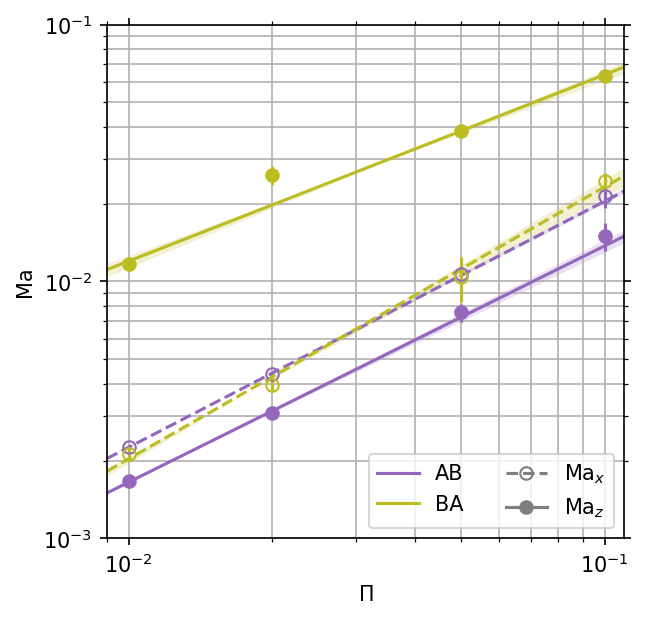

In [30]:
#==============================================================================
import sys
sys.path.insert(0, '/home/stanley/bitbucket/ccyang/athena-dust/vis/python')
import athena_read
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

fig, ax = plt.subplots(figsize=(4.45, 4.45), dpi=150)
workdir = '../unstrat'
cases = [['AB', 'tab:purple',  5], # [case, line style, t_sat]
         ['BA', 'tab:olive', 150]]
Pis = [0.01, 0.02, 0.05, 0.10]
res = '2048'
dirs = [['x', 'dux',   'dux2', 1, 'dashed', 'none'],
        ['z', '2-mom', '2-KE', 2, 'solid' , 'full']]
avgMas = np.zeros((len(Pis), len(dirs)))
stdMas = np.zeros((len(Pis), len(dirs)))
pow_law = lambda x, a, k : a*x**k
xs = np.linspace(9e-3, 1.1e-1)
runs, tdirs, a_arr, a_errs, k_arr, k_errs = [], [], [], [], [], []

for case in cases:
    print(f'{case[0]:s}/0.05')
    for i, dir in enumerate(dirs):
        for j, Pi in enumerate(Pis):
            path = f'{workdir}/{case[0]}/{Pi:0.2f}/{res}'
            athinput = athena_read.athinput(f'{path}/athinput.si')
            hst = athena_read.hst(f'{path}/output/SI.hst')
            i_sat = int(case[2]/athinput['output3']['dt'])
            Mg = hst['mass']
            dispersions = np.sqrt(dir[3]*hst[dir[2]]/Mg - (hst[dir[1]]/Mg)**2)
            Mas = dispersions/athinput['hydro']['iso_sound_speed']
            avgMas[j, i] = np.average(Mas[i_sat:])
            stdMas[j, i] = np.std(Mas[i_sat:])
            if Pi==0.05:
                print(f'\tMa_{dir[0]} = {avgMas[j, i]:.1e} ± {stdMas[j, i]:.0e}')

        popt, pcov = curve_fit(pow_law, Pis, avgMas[:, i], sigma=stdMas[:, i])
        perr = np.sqrt(np.diag(pcov))
        a, a_err, k, k_err = popt[0], perr[0], popt[1], perr[1]
        fit_low = pow_law(xs, a - a_err, k - k_err)
        fit_high = pow_law(xs, a + a_err, k + k_err)
        
        ax.errorbar(Pis, avgMas[:, i], 2*stdMas[:, i], fmt='o', color=case[1],
                    fillstyle=dir[5])
        ax.plot(xs, pow_law(xs, *popt), ls=dir[4], color=case[1])
        ax.fill_between(xs, fit_low, fit_high, color=case[1], ec=None,
                        alpha=0.2)
        runs.append(case[0]); tdirs.append(dir[0])
        a_arr.append(a); a_errs.append(a_err)
        k_arr.append(k); k_errs.append(k_err)

# Plot line style ghost points; format plots and legend
ax.plot([], [], color='tab:purple', label='AB')
ax.plot([], [], color='tab:olive', label='BA')
ax.plot([], [], color='tab:gray', ls='--', label='Ma$_x$', fillstyle='none',
        marker='o')
ax.plot([], [], color='tab:gray', label='Ma$_z$', marker='o')
ax.legend(loc='lower right', ncol=2)
ax.grid(which='both')
ax.minorticks_on()
ax.set(xlabel=r'$\Pi$', ylabel='Ma', xscale='log', yscale='log',
       xlim=(9e-3, 1.1e-1), ylim=(1e-3, 1e-1))
ax.tick_params(which='both', top=True, right=True)
plt.savefig('figs/machs.pdf', bbox_inches='tight', pad_inches=0.01)

df = pd.DataFrame({
    'Case' : runs,
    'Dir'  : tdirs,
    'a'    : ms,
    '±σ_a' : merrs,
    'k'    : bs,
    '±σ_k' : berrs,})
s = df.style.format({
    'a'    : '{:.4f}',
    '±σ_a' : '({:.0e})',
    'k'    : '{:.2e}',
    '±σ_k' : '({:.0e})',})
s